In [1]:
from __future__ import print_function
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions

Using TensorFlow backend.
/home/apoorve/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/apoorve/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/apoorve/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/apoorve/anaconda3/lib/python3.7/site-packages/t

In [2]:
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
# from scipy.misc import imsave

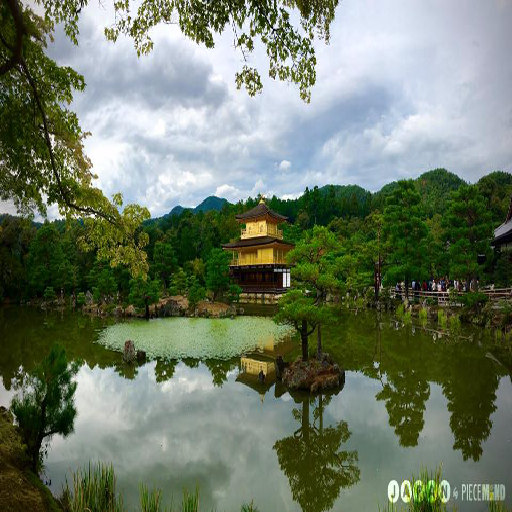

In [3]:
content_image=Image.open('japanese_garden.jpg')
content_image=content_image.resize((512,512))
content_image

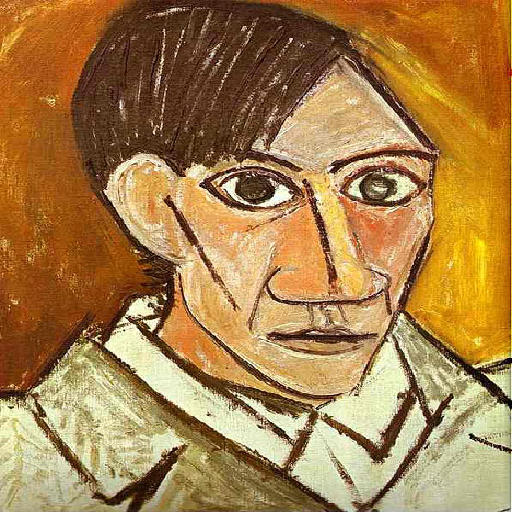

In [4]:
style_image= Image.open('picasso_selfportrait.jpg')
style_image=style_image.resize((512,512))
style_image

In [5]:
content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0)
#content_array=np.array(content_array).copy()

In [6]:
style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)
#backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))style_array=np.array(style_array).copy()
print(content_array.shape)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [7]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array=content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array=style_array[:, :, :, ::-1]

In [8]:
height=512
width=512
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))

In [9]:
input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)

In [10]:
model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)

In [11]:
content_weight = 0.05
style_weight = 5.0
total_variation_weight = 1.0

In [12]:
layers=dict([(layer.name, layer.output) for layer in model.layers])

In [13]:
loss=backend.variable(0.)

In [14]:
def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))

In [15]:
layer_features=layers['block2_conv2']
content_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss.assign_add(content_weight*content_loss(content_image_features,combination_features))

<tf.Variable 'AssignAddVariableOp' shape=() dtype=float32>

In [16]:
def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram

In [17]:
def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

In [18]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

In [19]:
for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss.assign_add((style_weight/len(feature_layers))*sl)

In [20]:
def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
loss .assign_add( total_variation_weight * total_variation_loss(combination_image))

<tf.Variable 'AssignAddVariableOp_6' shape=() dtype=float32>

In [21]:
grads = backend.gradients(loss, combination_image)

In [22]:
outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

In [23]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [24]:
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [25]:
evaluator=Evaluator()

In [26]:
x=np.random.uniform(0,255,(1,height,width,3))-128.0
iterations = 20

In [27]:
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0


AttributeError: 'NoneType' object has no attribute 'name'

In [ ]:
import tensorflow
print(tensorflow.__version__)
import keras
print(keras.__version__)

In [ ]:
print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

In [ ]:
Image.fromarray(x)

In [ ]:
final_plot_addresss = "/gdrive/My Drive/Colab Notebooks/Myelin_Neural_style_transfer/final.png"
final_plot = plt.imshow(Image.fromarray(x))
final_plot.figure.savefig(final_plot_addresss)

combined_plots_address = "/gdrive/My Drive/Colab Notebooks/Myelin_Neural_style_transfer/combined.png"

images = [content_image,style_image,Image.fromarray(x)]
new_im = Image.new('RGB', (width * 3, height))
x_offset = 0
for im in images:
  new_im.paste(im, (x_offset,0))
  x_offset += width

new_im.save(combined_plots_address)

# combined.save(combined_image_path)
combined_plot = plt.imshow(combined)
combined_plot.figure.savefig(combined_plots_address)